In [4]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
import lmfit
from lightkurve.lightcurve import LightCurve

from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import find_lines_threshold,fit_lines,estimate_line_parameters
from astropy.modeling import models
from specutils.analysis import centroid, fwhm, equivalent_width, line_flux
from astropy.nddata import NDUncertainty

#from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/belugawhale/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
wavelength, med, med_err = np.load('../data/mean_quiescent.npy')

In [9]:
lines = Table.read('/Users/belugawhale/Documents/AUMic/aumic_linelist.csv',format='csv')

In [10]:
def which_axis(axes,wavelength,line):
    o1_list = np.arange(0,13900,1,dtype=int).reshape((2,int((13900)/2)))
    o2_list = np.arange(14200,28640,1,dtype=int).reshape((2,int((28640-14200)/2)))
    
    if (line <= wavelength[o1_list[0]][-1]):
        a=axes[0]
    elif ((line > wavelength[o1_list[0]][-1]) and
          ((line < wavelength[o1_list[1]][-1]))):
        a=axes[1]
    elif ((line > wavelength[o1_list[1]][-1]) and
          ((line <= wavelength[o2_list[0]][-1]))):
        a=axes[2]
    else:
        a=axes[3]
    return a

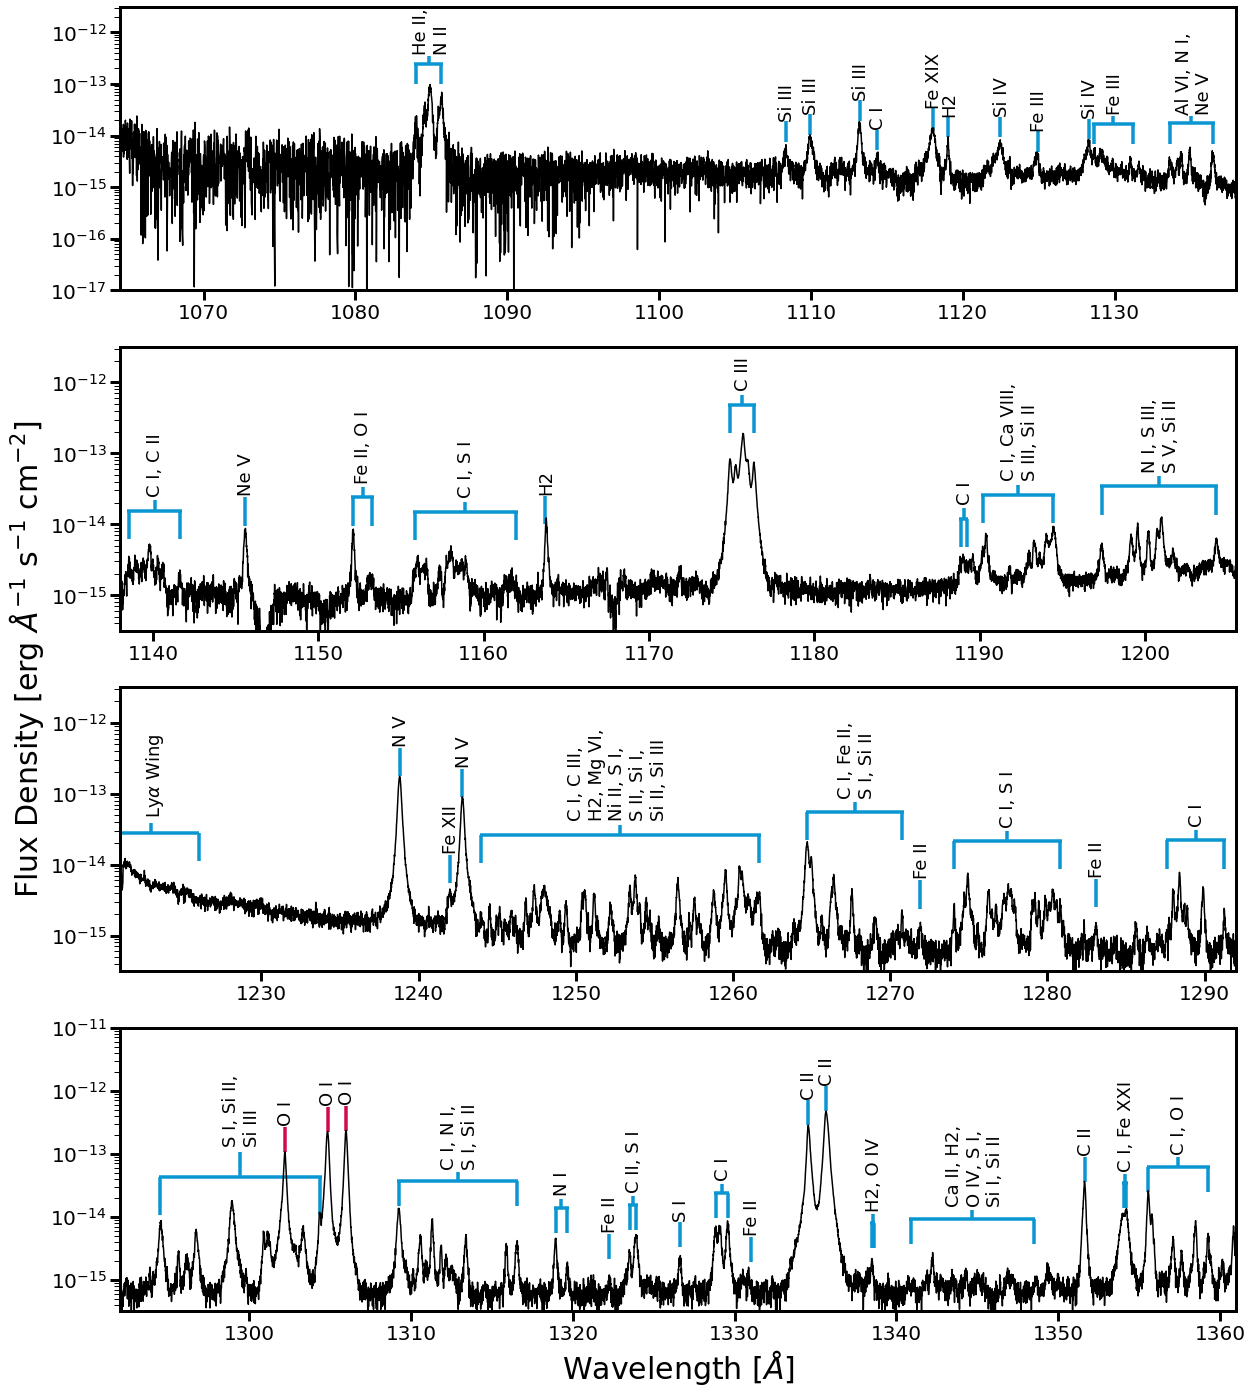

In [19]:
plt.rcParams['font.size'] = 20

lw=3.5

fig,allaxes = plt.subplots(nrows=4,ncols=1, figsize=(20,24))
fig.set_facecolor('w')

axes = allaxes.reshape(-1)
o1_list = np.arange(0,13900,1,dtype=int).reshape((2,int((13900)/2)))
o2_list = np.arange(14200,28640,1,dtype=int).reshape((2,int((28640-14200)/2)))

q = (med > 0) 

for i in range(len(lines)):
    a = which_axis(axes, wavelength[q], lines['wave_obs'][i])
    
    if type(lines['Forest'][i])==np.ma.core.MaskedConstant and lines['velocity_offset'][i]<25:
        ind = np.where(wavelength[q]>=lines['wave_obs'][i])[0][0]
        height = med[q][ind]+1e-15
        
        if lines['Ion'][i]=='O I':
            c='#d10a50'
        else:
            c=parula[80]
        
        a.vlines(lines['wave_obs'][i], height,height+height*1.5,
                  color=c,lw=lw)
        
        a.text(s=lines['Ion'][i], 
               y=height+height*2, 
               x=lines['wave_obs'][i]-0.5, 
               rotation=90,
               fontsize=18)
        
###########        
# LYMAN ALPHA LABEL
ind = np.where(wavelength[q]>=1121)[0][0]
height = med[q][ind]+1e-14
axes[2].hlines(height+height*1.5, 1220, 1226, lw=lw, color=c)
axes[2].vlines(1226, height,height+height*1.5,
                  color=c,lw=lw)
axes[2].vlines(1223, height+height*1.5,height+height*2.5,
                  color=c,lw=lw)
axes[2].text(s=r'Ly$\alpha$ Wing',
               y=height+height*4, 
               x=1222.5,
               rotation=90,
               fontsize=18)
###########

c=parula[80]        
for i in np.unique(lines['Forest'])[:-1]:
    templines = lines[(lines['Forest']==i)&(np.abs(lines['velocity_offset'])<30)]
    a = which_axis(axes, wavelength[q], templines['wave_obs'][0])
    
    ind1 = np.where(wavelength[q]>=templines['wave_obs'][0])[0][0]
    ind2 = np.where(wavelength[q]>=templines['wave_obs'][-1])[0][0]
    
    height = np.nanmax(med[q][ind1:ind2])+1e-15
    
    offset=0.8
    if len(np.unique(templines['Ion']))>2:
        names = [e for e in np.unique(templines['Ion']) if e!='?']
        breakup = np.arange(0,len(names),2,dtype=int)
        breakup = np.append(breakup,len(names))
        text=''
        for j in range(len(breakup)-1):
            links = names[breakup[j]:breakup[j+1]]
            text+=', '.join(str(e) for e in links)
            if j < len(breakup)-2:
                text+=',\n'
        if len(breakup)==3:
            offset=1.1
        elif len(breakup)==2:
            offset=0.6
        elif len(breakup)==4:
            offset=1.7
        else:
            offset=3.4
    else:
        text=', '.join(str(e) for e in np.unique(templines['Ion']) if e!='?')
        offset=0.5
    
    if text == 'He II, N II':
        text = 'He II,\nN II'
        offset=1.1
    
    if text=='S I, Si II,\nSi III':
        yt=height+height*0.4
        y1,y2,y3=height-height*0.9,height-height*0.6,height
    else:
        yt=height+height*3.5
        y1,y2,y3=height,height+height*1.5,height+height*2.5
        
    a.vlines(templines['wave_obs'][0], y1,y2,
                  color=c,lw=lw)
    a.vlines(np.nanmedian([templines['wave_obs'][0],templines['wave_obs'][-1]]), 
             y2, y3,
             color=c,lw=lw)
    a.vlines(templines['wave_obs'][-1], y1,y2,
                  color=parula[80],lw=lw)
    a.hlines(y2, templines['wave_obs'][0]-0.1, templines['wave_obs'][-1]+0.1,
             color=c,lw=lw)

    a.text(s=text,
          y=yt,
          x=np.nanmedian([templines['wave_obs'][0],templines['wave_obs'][-1]])-offset,
          rotation=90,
          fontsize=18)

x=0
xlims = [[1064.5, 1138], [1138, 1205.5],
         [1221, 1292], [1292, 1361]]
for i in range(len(axes)):
    where = np.where((wavelength[q]>=xlims[i][0]) &
                     (wavelength[q]<xlims[i][1]))
    axes[i].plot(wavelength[q][where],
                     med[q][where], 
                     color='k')

    axes[i].set_xlim(xlims[i])
    x += 1
    
    if x > 1:
        x=0
    if i ==1 or i==2:
        axes[i].set_ylim(10**-15.5,10**-11.5)
    elif i==0:
        axes[i].set_ylim(10**-17,10**-11.5)
    else:
        axes[i].set_ylim(10**-15.5,10**-11)
    axes[i].set_yscale('log')


axes[-1].set_xlabel('Wavelength [$\AA$]', fontsize=30)
axes[2].set_ylabel('Flux Density [erg $\AA^{-1}$ s$^{-1}$ cm$^{-2}$]', 
                   fontsize=30,
                   y=1.1)

for a in axes:
    a.set_rasterized(True)

#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/alllines.pdf', 
#            rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)

In [33]:
def load_data(path, fname='interp_between_1.npy'):
    wavelength, flux, err = load_binned_data(os.path.join(path,fname))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w30, w20, axis=0), 
                    flux=np.append(f30, f20, axis=0),
                    flux_err=np.append(e30, e20, axis=0), 
                    time=np.append(t30, t20)-t30[0], 
                    orbit=np.append(o30, o20+5))
fwc.identify_continuum()

In [36]:
fwc.continuum_mask[0]

array([1, 1, 1, ..., 1, 1, 1])

(0.0, 10.0)

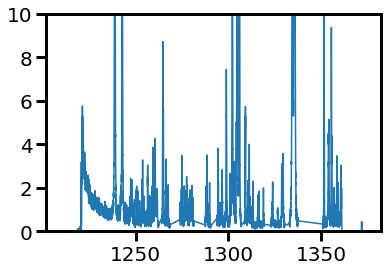

In [51]:
q = fwc.continuum_mask[0]!=0
q2 = wavelength[q] > 1210

plt.plot(wavelength[q][q2],med[q][q2]/med_err[q][q2])
plt.ylim(0,10)